In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

In [2]:
raw_data = pd.read_csv('used_cars_data.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
# we would like to predict the price of a used car depending on it's specifications

In [4]:
raw_data.describe(include = 'all')

# There are 312 models. It will be hard to implement this variable into a regression so we will drop it for now.
# We will also remove the missing values 

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [5]:
data = raw_data.drop(['Model'], axis =1)

In [6]:
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [7]:
data_no_mv = data.dropna(axis =0)

C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Price', ylabel='Density'>

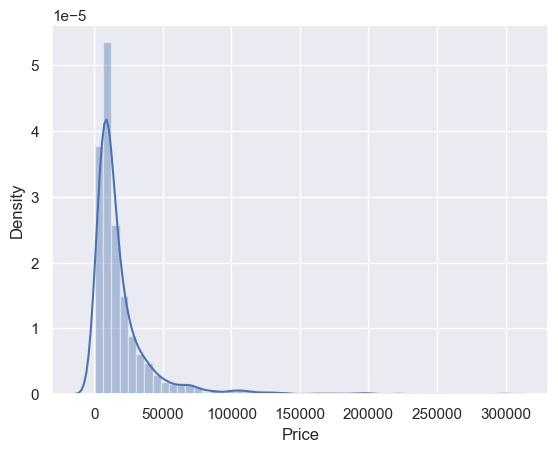

In [8]:
sns.distplot(data_no_mv['Price'])

# PDF of the price variable. 
# Price variable has an exponential distribution and it will be a problem for the regression
# When we check the price variable's descriptives, we can see that it's mean is around $19,000,
# 25% of the prices are under $7,000, 50% is below 11,500, 75% are lower than 21,900 yet the max price is $300,000.
# There are outliers in the price variable, which will cause coefficients to be inflated
# We will try removing the top 1% of observations to deal with the outliers

In [9]:
q = data_no_mv['Price'].quantile(0.99)
data_1 = data_no_mv[data_no_mv['Price'] < q]
data_1.describe(include = 'all')

# The price variable is still far away from the mean, but acceptably closer. 

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3984,3984.000000,3984,3984.000000,3984.000000,3984,3984,3984.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1528,NaN,NaN,1853,3613,NaN
mean,NaN,17837.117460,NaN,165.116466,2.743770,NaN,NaN,2006.292922
std,NaN,18976.268315,NaN,102.766126,4.956057,NaN,NaN,6.672745
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6980.000000,NaN,93.000000,1.800000,NaN,NaN,2002.750000
50%,NaN,11400.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21000.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000


C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Price', ylabel='Density'>

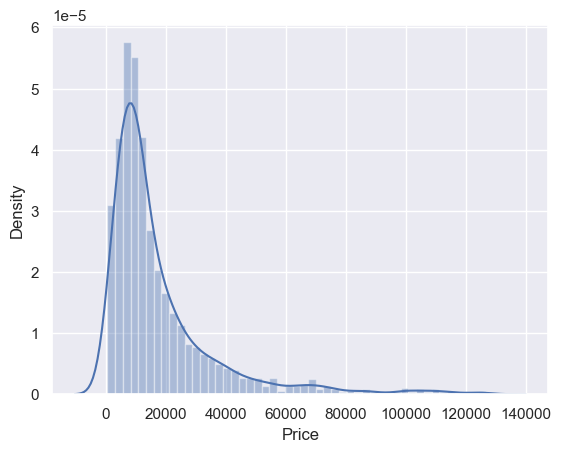

In [10]:
sns.distplot(data_1['Price'])

# The price variable is still distributed in the same manner but with less outliers. 

C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Mileage', ylabel='Density'>

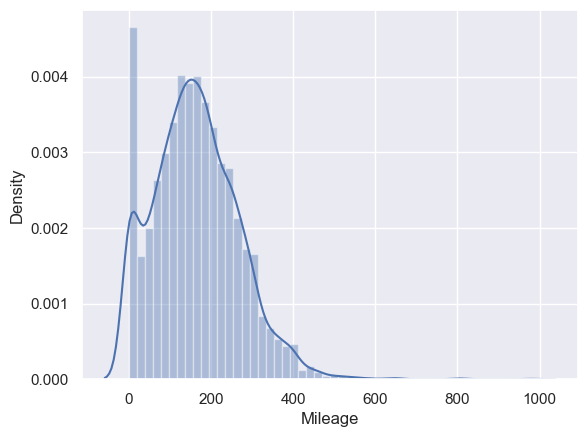

In [11]:
sns.distplot(data_no_mv['Mileage'])

# we will remove the outliers in the mileage variable as well with the same method.

C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Mileage', ylabel='Density'>

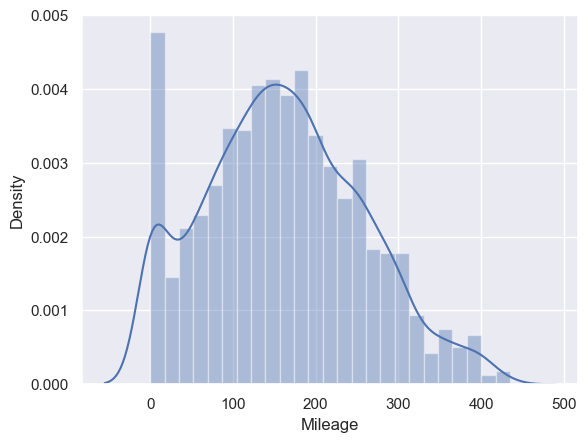

In [12]:
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage'] < q]

sns.distplot(data_2['Mileage'])

C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='EngineV', ylabel='Density'>

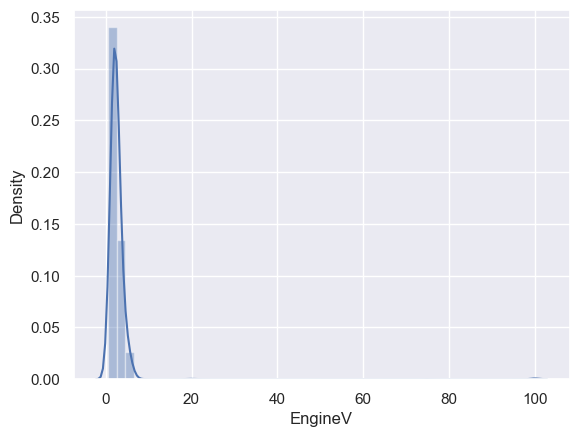

In [13]:
sns.distplot(data_no_mv['EngineV'])

C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='EngineV', ylabel='Density'>

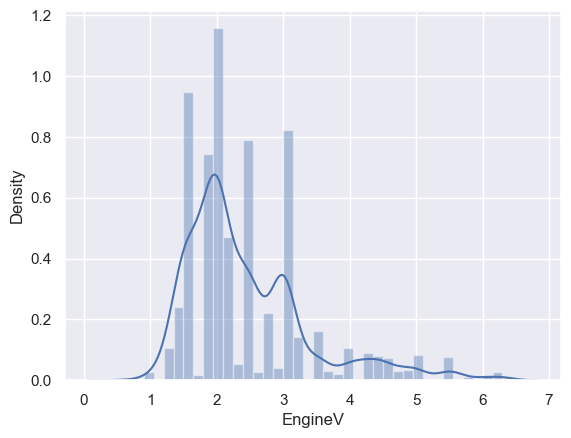

In [14]:
# There are values like 74, 90, 99.99 etc. in engine volume variables which are assigned values.
# 6.5 is the benchmark for Engine volume so we keep the values less than 6.5 only.

data_3 = data_2[data_2['EngineV'] < 6.5]
sns.distplot(data_3['EngineV'])


C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Year', ylabel='Density'>

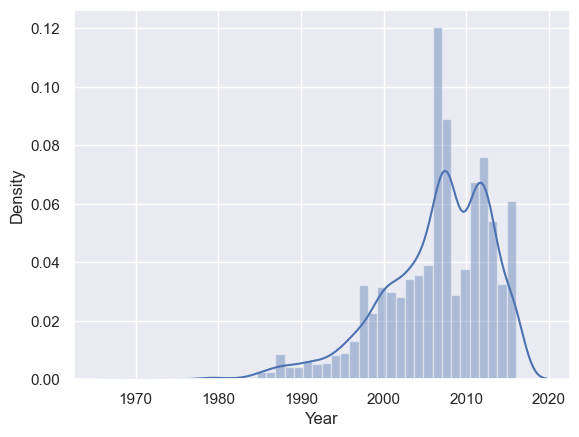

In [15]:
sns.distplot(data_3['Year'])
# most cars are newer but there seem to be a few old cars, therefore outliers are on the left side. 
# we will take the first quantile and keep the observations that are higher

C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Year', ylabel='Density'>

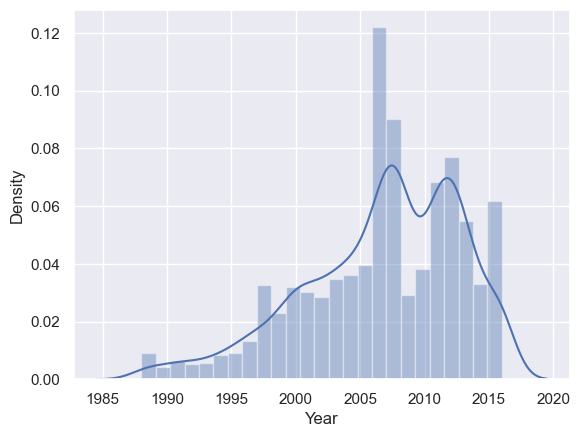

In [16]:
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year'] > q]

sns.distplot(data_4['Year'])

In [17]:
# resetting indexes 
data_cleaned = data_4.reset_index(drop = True)

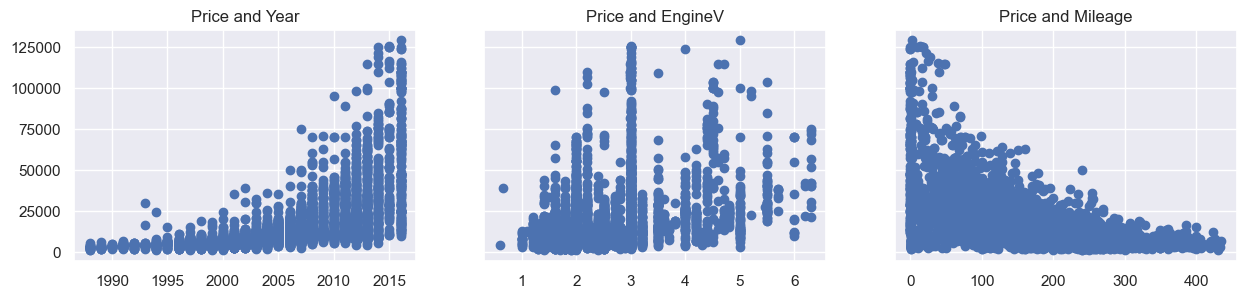

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) 
ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
ax3.set_title('Price and Mileage')


plt.show()

In [19]:
# we can't spot linear patterns in these plots. The price variable is not normally distributed
# and for that reason it's relationships with the other normally distributed features are not linear. 
# we will use log transformation on the price variable to fix the exponential scatter plot problem. 

log_price = np.log(data_cleaned['Price'])
data_cleaned['log_price'] = log_price

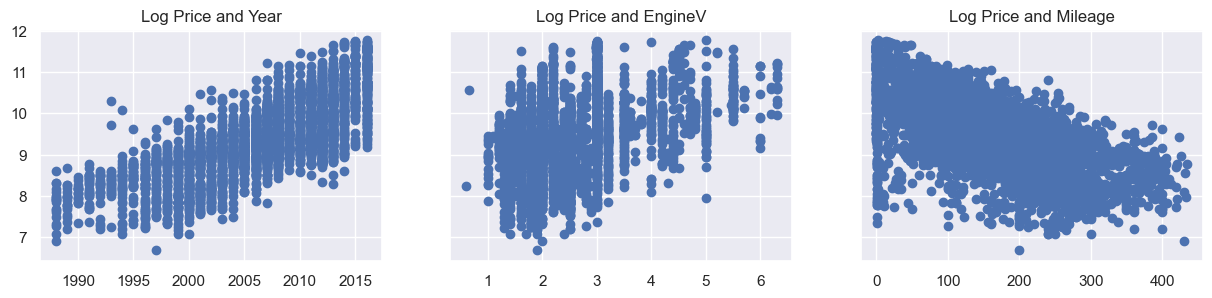

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')


plt.show()

# we can see linear patterns in all plots now. The lines fit the data so much better.

In [21]:
data_cleaned = data_cleaned.drop(['Price'],axis=1)
data_cleaned

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,crossover,120,2.0,Petrol,yes,2011,9.814656
...,...,...,...,...,...,...,...,...
3862,Volkswagen,van,163,2.5,Diesel,yes,2008,9.350102
3863,Toyota,sedan,35,1.6,Petrol,yes,2014,9.792556
3864,Mercedes-Benz,sedan,9,3.0,Diesel,yes,2014,11.736069
3865,BMW,sedan,1,3.5,Petrol,yes,1999,8.779557


In [22]:
# we will use statsmodels VIF to check for multicollinearity. 

from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_cleaned[['Mileage', 'Year', 'EngineV']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif

,VIF,features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


In [23]:
# The year of manufacture is definitely correlated with the other variables so we will remove Year variable. 

data_no_multicollinearity = data_cleaned.drop(['Year'], axis =1)

In [24]:
# creating dummies
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first = True)
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [25]:
# Rearranging the columns 
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [26]:
cols = ['log_price', 'Mileage', 'EngineV','Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

In [27]:
data_preprocessed = data_with_dummies[cols]

In [28]:
targets = data_preprocessed['log_price']
inputs = data_preprocessed.drop(['log_price'],axis=1)

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler()

In [30]:
inputs_scaled = scaler.transform(inputs)

In [31]:
# we will do an 80-20 split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size = 0.2, random_state = 42)

In [32]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [33]:
y_hat = reg.predict(x_train)

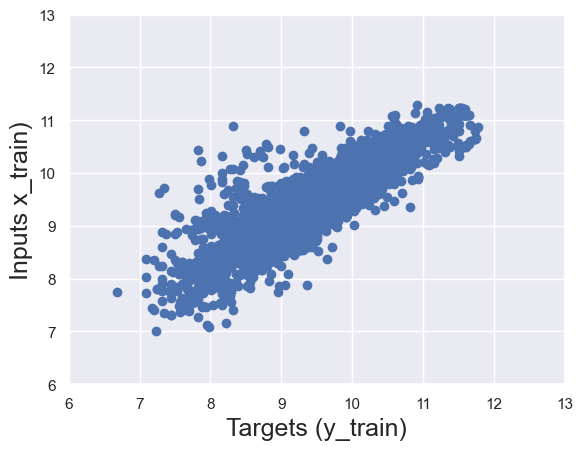

In [34]:
# plotting the predicted values of the regression against the observed values
plt.scatter(y_train, y_hat)
plt.xlabel('Targets (y_train)', size =18)
plt.ylabel('Inputs x_train)', size =18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

C:\Users\merve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals PDF')

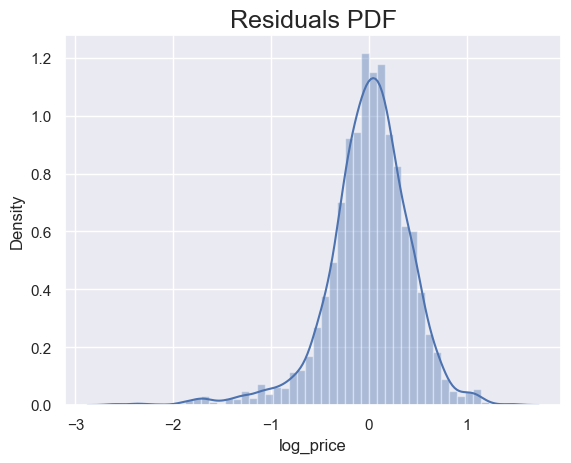

In [35]:
# Looks very close to a normal distribution but there is a much longer tail on the negative side.
# Therefore there are certain observations for which (y_train - y_hat) is much lower than the mean. 
# Meaning a much higher price is predicted with our model than what is observed. 

sns.distplot(y_train - y_hat)
plt.title('Residuals PDF', size =18)

In [36]:
# Our model is explaining 75% of the variability of the data.
reg.score(x_train, y_train)

0.7546487921881218

In [37]:
# finding bias
reg.intercept_

9.421003614148074

In [38]:
# finding weights
reg.coef_

array([-0.46815598,  0.21526817,  0.01105151,  0.00569157, -0.14247174,
       -0.18769337, -0.06529696, -0.09898873, -0.13980763, -0.09384461,
       -0.17892753, -0.11457574, -0.15668036, -0.11685263, -0.02572253,
       -0.15106183,  0.31442123])

In [39]:
# creating a summary table with bias and weights
reg_summary = pd.DataFrame(inputs.columns.values, columns = ['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

# A positive weight shows that as a feature increases in value, so do the 'log_price' and 'Price' variables respectively
# Like the 'EngineV' variable, the bigger the engine volume, the higher the price.
# A negative weight shows that as a feature increases in value, 'log_price' and 'Price' decrease.
# like the 'Mileage' variable, the more a car is being driven the lower the price gets.
# When it comes to dummy variables we have to find the benchmarks.
# For Brand variable Audi is the dropped brand so it is the benchmark.
# A positive weight shows that the respective category (Brand) is more expensive than the benchmark (Audi)
# For instance, BMW's coefficient is positive so on average if a car is a BMW, it will be more expensive than an Audi
# Similarly, if a car is a Mitsubishi it will be cheaper than an Audi
# Mileage is the most important feature in this regression as it has the highest weight in all features. 

,Features,Weights
0,Mileage,-0.468156
1,EngineV,0.215268
2,Brand_BMW,0.011052
3,Brand_Mercedes-Benz,0.005692
4,Brand_Mitsubishi,-0.142472
5,Brand_Renault,-0.187693
6,Brand_Toyota,-0.065297
7,Brand_Volkswagen,-0.098989
8,Body_hatch,-0.139808
9,Body_other,-0.093845


In [40]:
y_hat_test = reg.predict(x_test)

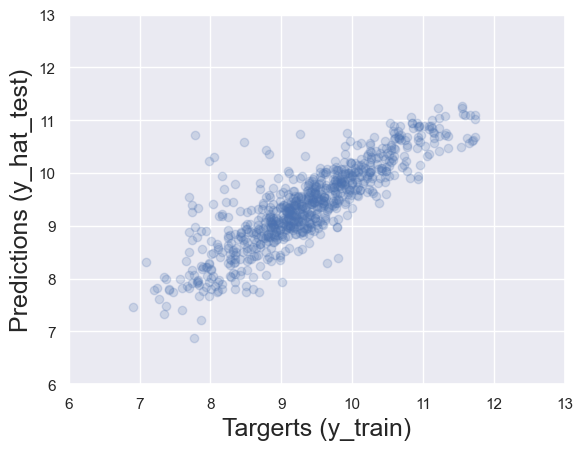

In [41]:
# For higher prices, we have a higher concentration of values around the 45 degree line
# Therefore our model is very good at predicting higher prices.
# But lower prices are much more scattered so we are not quite getting the prices right. 

plt.scatter(y_test, y_hat_test, alpha =0.2)
plt.xlabel('Targerts (y_train)', size=18)
plt.ylabel('Predictions (y_hat_test)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [42]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns = ['Prediction'])
df_pf.head()

,Prediction
0,40419.308971
1,7956.895960
2,5757.284408
3,9765.810605
4,7027.363814


In [43]:
y_test = y_test.reset_index(drop = True)

In [44]:
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,40419.308971,21300.0
1,7956.895960,8900.0
2,5757.284408,3250.0
3,9765.810605,12000.0
4,7027.363814,5400.0
...,...,...
769,4699.586013,4200.0
770,9123.067372,8800.0
771,6267.803094,4850.0
772,20906.128600,27000.0


In [45]:
df_pf['Residuals'] = df_pf['Target'] - df_pf['Prediction']

In [46]:
# The minimum difference in percentages is 0.06% so the output was spot on.
# The max is 512% so it is pretty off from the target.
# 25%, 50%, 75% percentiles tell us that for most of our predictions we got relatively close. 


df_pf['Difference%'] = np.absolute(df_pf['Residuals']/ df_pf['Target']*100)
df_pf.describe()

,Prediction,Target,Residuals,Difference%
count,774.000000,774.000000,774.000000,774.000000
mean,16113.011638,17799.988992,1686.977355,42.085282
std,13326.229797,19723.434542,11192.614496,96.169928
min,967.030415,999.000000,-42859.020603,0.020246
25%,7467.591694,6700.000000,-2246.354353,11.024941
50%,11914.358989,11050.000000,-38.697776,24.086183
75%,20249.505640,20475.000000,3004.524837,42.381716
max,79026.348020,125000.000000,81051.158885,1785.792525


In [47]:
# Going to the bottom of the dataframe we see that there are very few predictions dramatically far off from the observed values.
# The observed prices are extremely low.
# All residuals for these outliers are negative therefore their predictions are higher than the targets
# An explanation might be that we are missing an important factor which drives the price of a used car lower. 
# To improve our model we can try: 
# to use a different set of variables
# removing a bigger part of the outliers
# including 'Model' variable into the regression

pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residuals,Difference%
387,13602.75,13600.00,-2.75,0.02
74,28889.06,28900.00,10.94,0.04
314,35530.21,35500.00,-30.21,0.09
336,11313.27,11300.00,-13.27,0.12
425,2995.68,3000.00,4.32,0.14
262,52180.11,52055.25,-124.86,0.24
674,3107.51,3100.00,-7.51,0.24
648,9675.57,9700.00,24.43,0.25
79,21407.59,21335.00,-72.59,0.34
313,9865.72,9900.00,34.28,0.35
